# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import pickle
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning & Data Analyzing

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
(portfolio.isnull().sum()/portfolio.shape[0])*100

channels      0.0
difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
dtype: float64

The `portfolio` dataset doesn't contains any missing value

In [4]:
portfolio.channels.unique

<bound method Series.unique of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

In [5]:
# Cleaning the portfolio dataset
channel_list = ['web','email','mobile','social']
#One hot encoding for channels
for channel in channel_list:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
#One hot encoding for offer_type
portfolio['offer_type'] = portfolio['offer_type'].apply(lambda x: 0 if x == 'bogo' else 1 if x == 'discount' else 2)
# Now convert the duration from day to hours, because the transcript dataset contains time in terms of hours
portfolio['duration'] = portfolio['duration']*24
portfolio.drop(['reward'],axis=1,inplace=True)
portfolio.head()

,channels,difficulty,duration,id,offer_type,web,email,mobile,social
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,1,1
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,1,1,1
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,2,1,1,1,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1,0
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
print((profile.isnull().sum()/profile.shape[0])*100)
print("--------------------------")
print((profile[profile['age']==118].isnull().sum()/len(profile[profile['age']==118]))*100)

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64
--------------------------
age                   0.0
became_member_on      0.0
gender              100.0
id                    0.0
income              100.0
dtype: float64


##### Here we have to notice one thing, only 118's age people has null value, it seems like 118 represents the null value for `Age` column

In [8]:
#Cleaning Profile Dataset
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile.dropna(axis=0,inplace=True)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
profile['membership_days'] = (datetime.datetime.today().date() - profile['became_member_on'].dt.date).dt.days
profile.head()

,age,became_member_on,gender,id,income,membership_days
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1041
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1108
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,756
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,832
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,922


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [11]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

#### Here we are going to extract the data where  offer has been recieved or offer has been veiwed or offer is completed, because the remaining user has not recieved offer. It can be easily done by checking where offer_id/offer id is available

In [12]:
offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
offer['value'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
offer.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [13]:
df_trans = transcript[transcript.event == 'transaction']
df_trans['amount'] = df_trans.value.apply(lambda x:list(x.values())[0])
df_recieve = transcript[transcript.event == 'offer received']
df_recieve['offer_id'] = df_recieve.value.apply(lambda x:list(x.values())[0])
df_view = transcript[transcript.event == 'offer viewed']
df_view['offer_id'] = df_view.value.apply(lambda x:list(x.values())[0])
df_comp = transcript[transcript.event == 'offer completed']
df_comp['offer_id'] = df_comp.value.apply(lambda x:list(x.values())[0])
df_comp['reward'] = df_comp.value.apply(lambda x:list(x.values())[1])

transcript = pd.concat([df_trans,df_recieve,df_view,df_comp])
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)
transcript.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


# Data Visualization

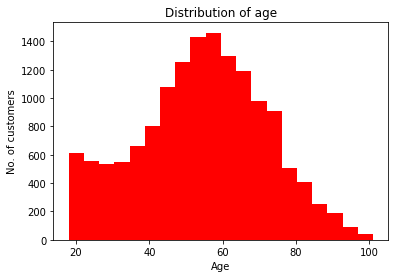

In [14]:
profile['age'].plot(kind = 'hist', bins = 20, color = 'red',title = 'Distribution of age')
plt.xlabel('Age')
plt.ylabel('No. of customers')
plt.show()

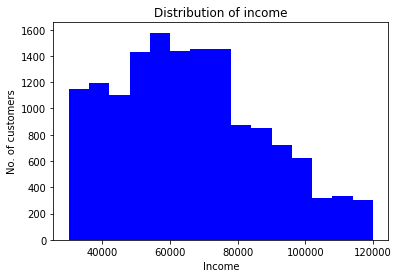

In [15]:
profile['income'].plot(kind = 'hist', bins = 15, color = 'blue', title = 'Distribution of income')
plt.xlabel('Income')
plt.ylabel('No. of customers')
plt.show()

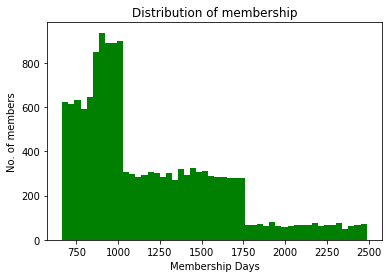

In [16]:
profile['membership_days'].plot(kind = 'hist', bins = 50, color = 'green', title = 'Distribution of membership')
plt.xlabel('Membership Days')
plt.ylabel('No. of members')
plt.show()

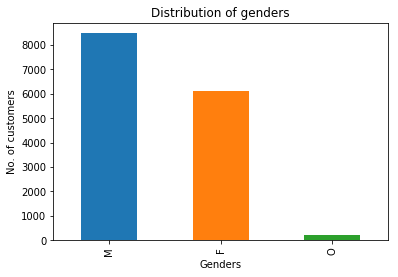

In [17]:
profile['gender'].value_counts().plot(kind = 'bar', title = 'Distribution of genders')
plt.xlabel('Genders')
plt.ylabel('No. of customers')
plt.show()

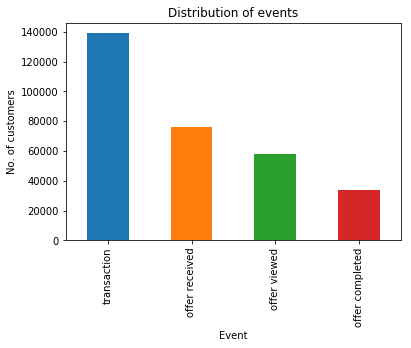

In [18]:
transcript['event'].value_counts().plot(kind = 'bar', title = 'Distribution of events')
plt.xlabel('Event')
plt.ylabel('No. of customers')
plt.show()

# Data Preparation

In [19]:
transcript[transcript.duplicated() == True].count()

event       397
person      397
offer_id    397
time        397
amount        0
reward      397
dtype: int64

In [20]:
#dropping duplicates:
transcript.drop_duplicates(inplace=True)

In [21]:
x = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript,x],axis=1)
#merging the transcript and profile data
merged_data = pd.merge(transcript,profile, left_on='person', right_on='id', how='inner')
merged_data.drop(columns=['id'],inplace = True)
# Replace Nans with 0
merged_data.reward.fillna(0 , inplace=True)
merged_data.amount.fillna(0 , inplace=True)
merged_data.head()

,event,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,membership_days
0,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,0.0,0,0,0,1,20.0,2016-07-11,F,30000.0,1410
1,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,6,1.44,0.0,0,0,0,1,20.0,2016-07-11,F,30000.0,1410
2,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,12,4.56,0.0,0,0,0,1,20.0,2016-07-11,F,30000.0,1410
3,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,84,1.53,0.0,0,0,0,1,20.0,2016-07-11,F,30000.0,1410
4,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,90,0.50,0.0,0,0,0,1,20.0,2016-07-11,F,30000.0,1410


In [22]:
merged_data['offer_id'].isnull().sum()/merged_data.shape[0]

0.45507511344112073

In [23]:
merged_data.dropna(subset=['offer_id'],inplace=True)

In [24]:
merged_data = merged_data.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')
merged_data.head()

,event,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,...,membership_days,channels,difficulty,duration,id,offer_type,web,email,mobile,social
0,offer received,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,...,1410,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,1,1
1,offer received,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,0.0,0.0,0,1,0,0,...,1410,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0
2,offer viewed,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,0,1,0,...,1410,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,1,1
3,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0.0,0.0,0,1,0,0,...,1586,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,1,0
4,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,336,0.0,0.0,0,1,0,0,...,1586,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1


In [25]:
merged_data.drop(['event','id','duration','channels','time'],axis = 1,inplace = True)
merged_data.head()

,person,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,membership_days,difficulty,offer_type,web,email,mobile,social
0,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,0,1,0,0,20.0,2016-07-11,F,30000.0,1410,10,0,0,1,1,1
1,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0,1,0,0,20.0,2016-07-11,F,30000.0,1410,20,1,1,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,0,0,1,0,20.0,2016-07-11,F,30000.0,1410,10,0,0,1,1,1
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0,1,0,0,42.0,2016-01-17,M,96000.0,1586,10,1,1,1,1,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0,0,1,0,0,42.0,2016-01-17,M,96000.0,1586,7,1,1,1,1,1


__This encoding is done by Label Encoder__<br>
`fafdcd668e3743c1bb461111dcafc2a4`  ==>  <b>9</b><br>
`2298d6c36e964ae4a3e7e9706d1fb8c2`  ==>  <b>1</b><br>
`f19421c1d4aa40978ebb69ca19b0e20d`  ==>  <b>8</b><br>
`4d5c57ea9a6940dd891ad53e9dbe8da0`  ==>  <b>4</b><br>
`ae264e3637204a6fb9bb56bc8210ddfd`  ==>  <b>7</b><br>
`9b98b8c7a33c4b65b9aebfe6a799e6d9`  ==>  <b>6</b><br>
`2906b810c7d4411798c6938adc9daaa5`  ==>  <b>2</b><br>
`5a8bc65990b245e5a138643cd4eb9837`  ==>  <b>5</b><br>
`0b1e1539f2cc45b7b9fa7c272da2e1d7`  ==>  <b>0</b><br>
`3f207df678b143eea3cee63160fa8bed`  ==>  <b>3</b><br>

In [26]:
lbl = LabelEncoder()
merged_data['offer_id'] = lbl.fit_transform(merged_data['offer_id'])
merged_data['gender'] = lbl.fit_transform(merged_data['gender'])
merged_data.head()

,person,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,membership_days,difficulty,offer_type,web,email,mobile,social
0,02c083884c7d45b39cc68e1314fec56c,7,0.0,0.0,0,1,0,0,20.0,2016-07-11,0,30000.0,1410,10,0,0,1,1,1
1,02c083884c7d45b39cc68e1314fec56c,0,0.0,0.0,0,1,0,0,20.0,2016-07-11,0,30000.0,1410,20,1,1,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,7,0.0,0.0,0,0,1,0,20.0,2016-07-11,0,30000.0,1410,10,0,0,1,1,1
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2,0.0,0.0,0,1,0,0,42.0,2016-01-17,1,96000.0,1586,10,1,1,1,1,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.0,0.0,0,1,0,0,42.0,2016-01-17,1,96000.0,1586,7,1,1,1,1,1


# Data Modelling

In [27]:
df = merged_data[['age','gender','income','difficulty','web','email','mobile','social','offer_id']]
df.head()

,age,gender,income,difficulty,web,email,mobile,social,offer_id
0,20.0,0,30000.0,10,0,1,1,1,7
1,20.0,0,30000.0,20,1,1,0,0,0
2,20.0,0,30000.0,10,0,1,1,1,7
3,42.0,1,96000.0,10,1,1,1,0,2
4,42.0,1,96000.0,7,1,1,1,1,1


In [28]:
X_train = df.iloc[:,:-1]
Y_train = df.iloc[:,-1:]

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [30]:
print("Training Accuracy:",knn.score(X_train,Y_train)*100)

Training Accuracy: 91.5098598002


`Gender` --> MALE = 1, FEMALE = 0<br>
`web` --> YES = 1, NO = 0<br>
`email` --> YES = 1, NO = 0<br>
`mobile` --> YES = 1, NO = 0<br>
`social` --> YES = 1, NO = 0<br>

In [31]:
dic = {0:'0b1e1539f2cc45b7b9fa7c272da2e1d7',
       1:'2298d6c36e964ae4a3e7e9706d1fb8c2',
       2:'2906b810c7d4411798c6938adc9daaa5',
       3:'3f207df678b143eea3cee63160fa8bed',
       4:'4d5c57ea9a6940dd891ad53e9dbe8da0',
       5:'5a8bc65990b245e5a138643cd4eb9837',
       6:'9b98b8c7a33c4b65b9aebfe6a799e6d9',
       7:'ae264e3637204a6fb9bb56bc8210ddfd',
       8:'f19421c1d4aa40978ebb69ca19b0e20d',
       9:'fafdcd668e3743c1bb461111dcafc2a4'
      }

def customer_offer_classification(customer):
    customer['gender'] = customer['gender'].apply(lambda x: 1 if x == 'M' or 'm' else 0)
    customer['web'] = customer['web'].apply(lambda x: 1 if x == 'Y' or 'y' else 0)
    customer['email'] = customer['email'].apply(lambda x: 1 if x == 'Y' or 'y' else 0)
    customer['mobile'] = customer['mobile'].apply(lambda x: 1 if x == 'Y' or 'y' else 0)
    customer['social'] = customer['social'].apply(lambda x: 1 if x == 'Y' or 'y' else 0)
    customer_offer = knn.predict(customer)
    print("The offer id for this customer:",dic[customer_offer[0]])

In [32]:
def customer_details():
    age = float(input('What is the age? -> '))
    gender = input('Gender: M/F? -> ')
    income = float(input('How much the customer earns? -> '))
    difficulty = int(input('Enter the difficulty for getting offer:? -> '))
    web = input("web?Y/N -> ")
    email = input("email?Y/N -> ")
    mobile = input("mobile?Y/N -> ")
    social = input("social?Y/N -> ")
    customer = pd.DataFrame([[age,gender,income,difficulty,web,email,mobile,social]],
                            columns = ['age','gender','income','difficulty','web','email','mobile','social'])
    customer_offer_classification(customer)

In [33]:
customer_details()

What is the age? -> 36
Gender: M/F? -> f
How much the customer earns? -> 60000
Enter the difficulty for getting offer:? -> 17
web?Y/N -> y
email?Y/N -> y
mobile?Y/N -> n
social?Y/N -> y
The offer id for this customer: 0b1e1539f2cc45b7b9fa7c272da2e1d7
